(mmm_example)=
# MMM Example Notebook

In this notebook we work out a simulated example to showcase the media mix Model (MMM) API from `pymc-marketing`. This package provides a `pymc` implementation of the MMM presented in the paper [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/). We work with synthetic data as we want to do *parameter recovery* to better understand the model assumptions. That is, we explicitly set values for our adstock and saturation parameters (see model specification below) and recover them back from the model. The data generation process is as an adaptation of the blog post ["Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/) by [Juan Orduz](https://juanitorduz.github.io/).

## Business Problem

Before jumping into the data, let's first define the business problem we are trying to solve. We are a marketing agency and we want to optimize the marketing budget of a client. We have access to the following data:

- Sales data: weekly sales of the client.
- Media spend data: weekly spend on different media channels (e.g. TV, radio, online, etc.). In ths example we consider 2 media channels: $x_{1}$ and $x_{2}$.
- Domain knowledge: 
  - We know that there has a been an positive sales trend which we believe comes from a strong economic growth.
  - We also know that there is a yearly seasonality effect.
  - In addition, we were informed about two outliers in the data during the weeks `2019-05-13` and `2021-09-14`.

What do we mean by optimize the marketing budget? We want to find the optimal media mix that maximizes sales. In order to do so, we need to understand the mechanism in which the media spend for each channel affects sales. In other words, we need to understand the media contribution. The main challenge is that the direct cost signal does not translate into a linear contribution. For example, a $10\%$ increase in channel $x_{1}$ spend does not necessarily translate into a $10\%$ increase in sales. This can be explained by two phenomena

1. On the one hand side, there is a carry-over effect. That is, the effect of spend on sales is not instantaneous but accumulates over time.
2. In addition, there is a saturation effect. That is, the effect of spend on sales is not linear but saturates at some point.

In this example we will illustrate how we can use `pymc-marketing` to model these effects.

In the next section we describe a general framework for modeling media effects.

## Model Specification

In `pymc-marketing` we provide an API for a Bayesian media mix model (MMM) specification following [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017).](https://research.google/pubs/pub46001/). Concretely, given a time series target variable $y_{t}$ (e.g. sales or conversions), media variables $x_{m, t}$ (e.g. impressions, clicks or costs) and a set of control covariates $z_{c, t}$ (e.g. holidays, special events) we consider a linear model of the form 

$$
y_{t} = \alpha + \sum_{m=1}^{M}\beta_{m}f(x_{m, t}) +  \sum_{c=1}^{C}\gamma_{c}z_{c, t} + \varepsilon_{t},
$$

where $\alpha$ is the intercept, $f$ is a media transformation function and $\varepsilon_{t}$ is the error therm which we assume is normally distributed. The function $f$ encodes the contribution of media on the target variable. Typically we consider two types of transformation: adstock (carry-over) and saturation effects.

### References:

- [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017).](https://research.google/pubs/pub46001/)
- PyMC Labs Blog:
  - [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/)
  - [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/)
- [Johns, Michael and Wang,  Zhenyu. "A Bayesian Approach to Media Mix Modeling"](https://www.youtube.com/watch?v=UznM_-_760Y)
- [Orduz, Juan. "Media Effect Estimation with PyMC: Adstock, Saturation & Diminishing Returns"](https://juanitorduz.github.io/pymc_mmm/)

---

## Part I: Data Generation Process

In Part I of this notebook we focus on the data generating process. That is, we want to construct the target variable $y_{t}$ (sales) by adding each of the components described in the *Business Problem* section.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from pymc_marketing.mmm.delayed_saturated_mmm import DelayedSaturatedMMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

### 1. Date Range

First we set a time range for our data. We consider a bit more than 2 years of data at weekly granularity.

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 179


### 2. Media Costs Data

Now we generate synthetic data from two channels $x_1$ and $x_2$. We refer to it as the raw signal as it is going to be the input at the modeling phase. We expect the contribution of each channel to be different, based on the carryover and saturation parameters.

- Raw Signal

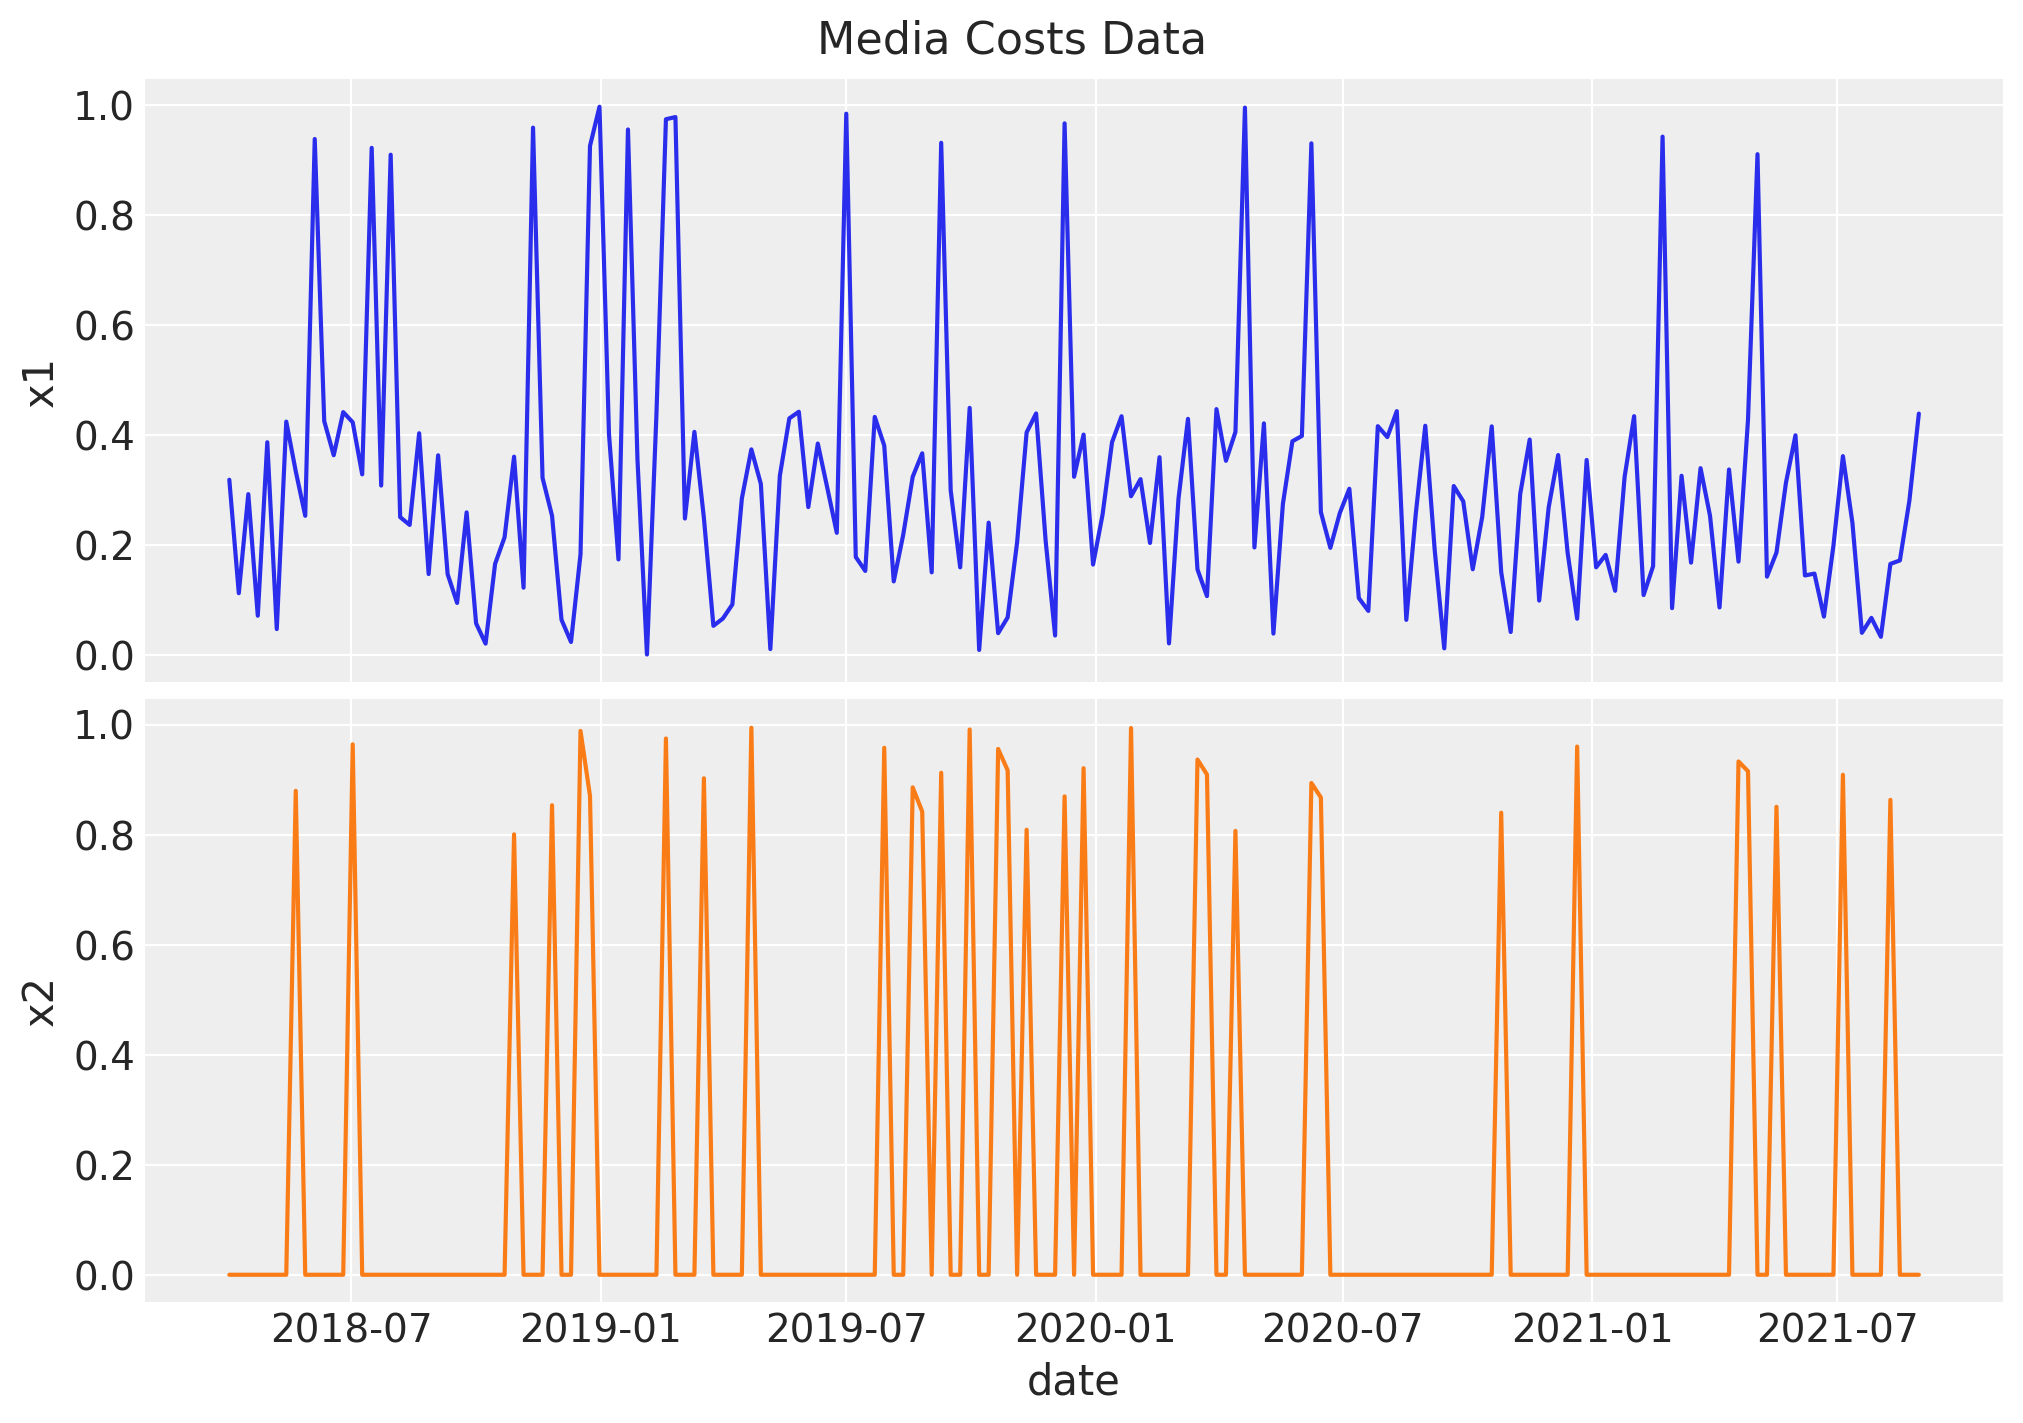

In [3]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)

x2 = rng.uniform(low=0.0, high=1.0, size=n)
df["x2"] = np.where(x2 > 0.8, x2, 0)


fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

**Remark:** By design, $x_{1}$ should resemble a typical paid social channel and $x_{2}$ a offline (e.g. TV) spend time series.

- Effect Signal

Next, we pass the raw signal through the two transformations: first the geometric adstock (carryover effect) and then the logistic saturation. Note that we set the parameters ourselves, but we will recover them back from the model.

Let's start with the adstock transformation. We set the adstock parameter $0 < \alpha < 1$ to be $0.4$ and $0.2$ for $x_1$ and $x_2$ respectively. We set a maximum lag effect of $8$ weeks.

In [4]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

Next, we compose the resulting adstock signals with the logistic saturation function. We set the parameter $\lambda > 0$ to be $4$ and $3$ for $z_1$ and $z_2$ respectively.

In [5]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

We can now visualize the effect signal for each channel after each transformation:

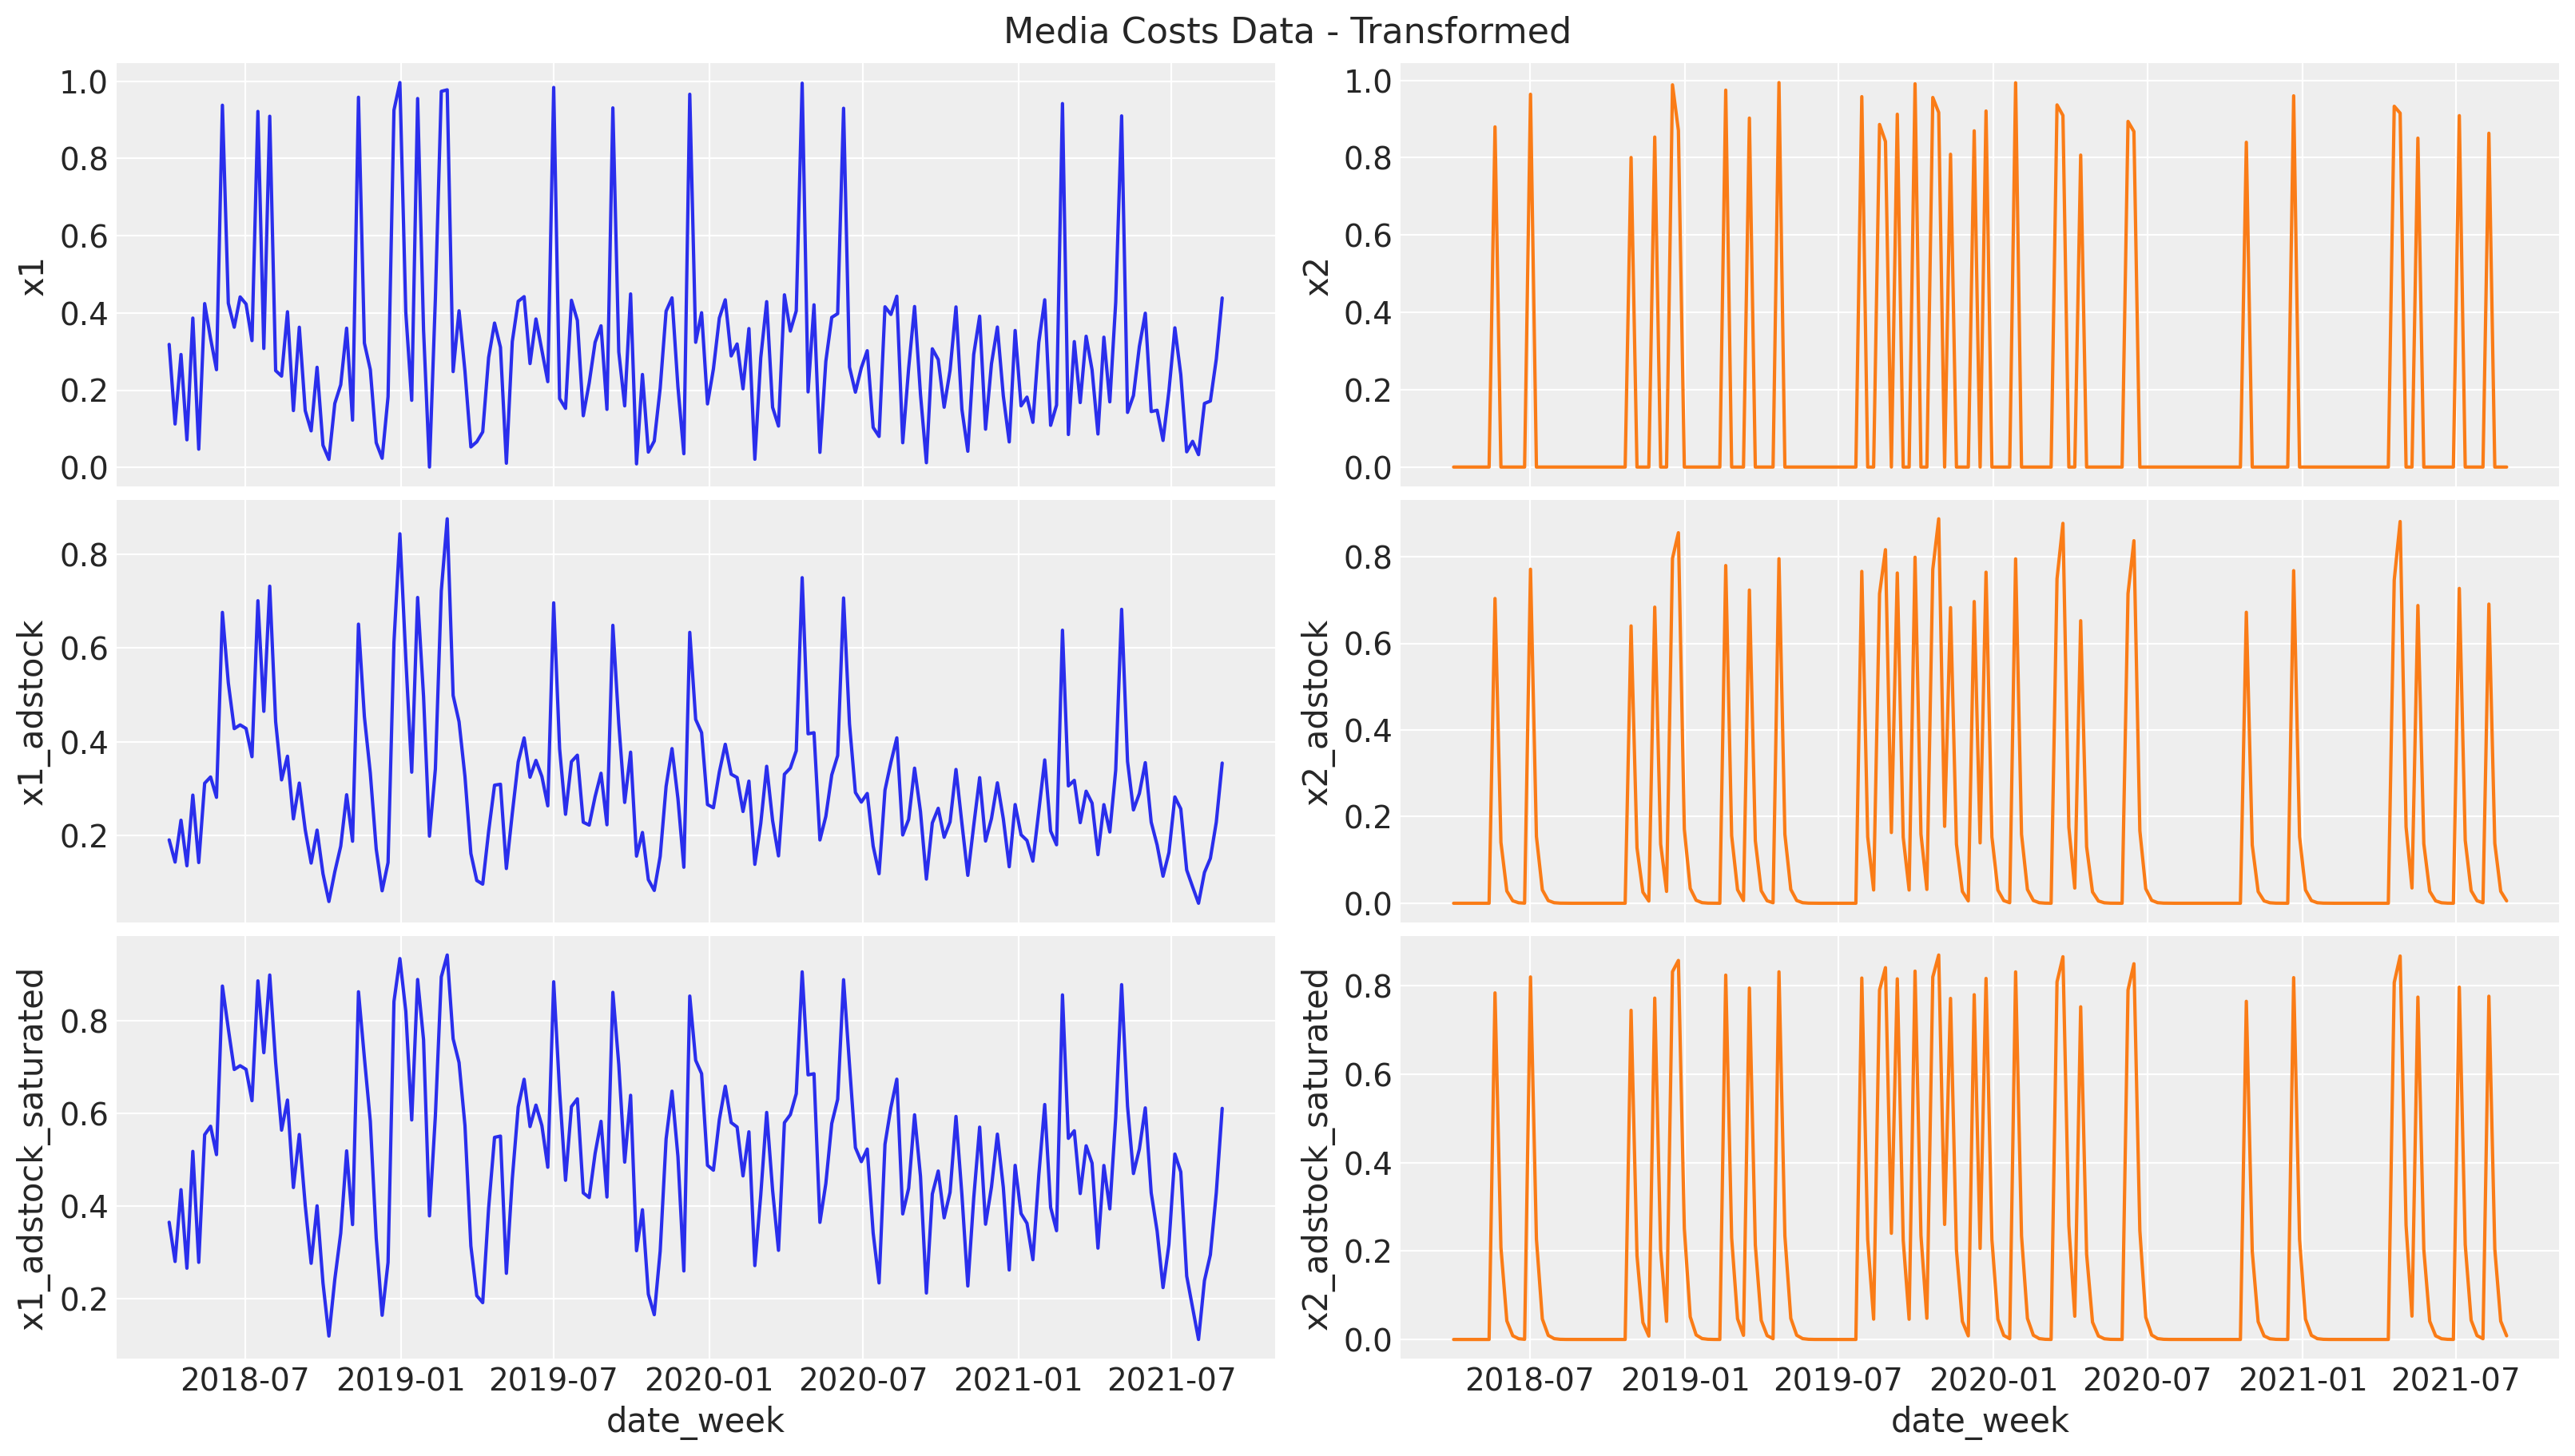

In [6]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

### 3. Trend \& Seasonal Components

Now we add synthetic trend and seasonal components to the effect signal.

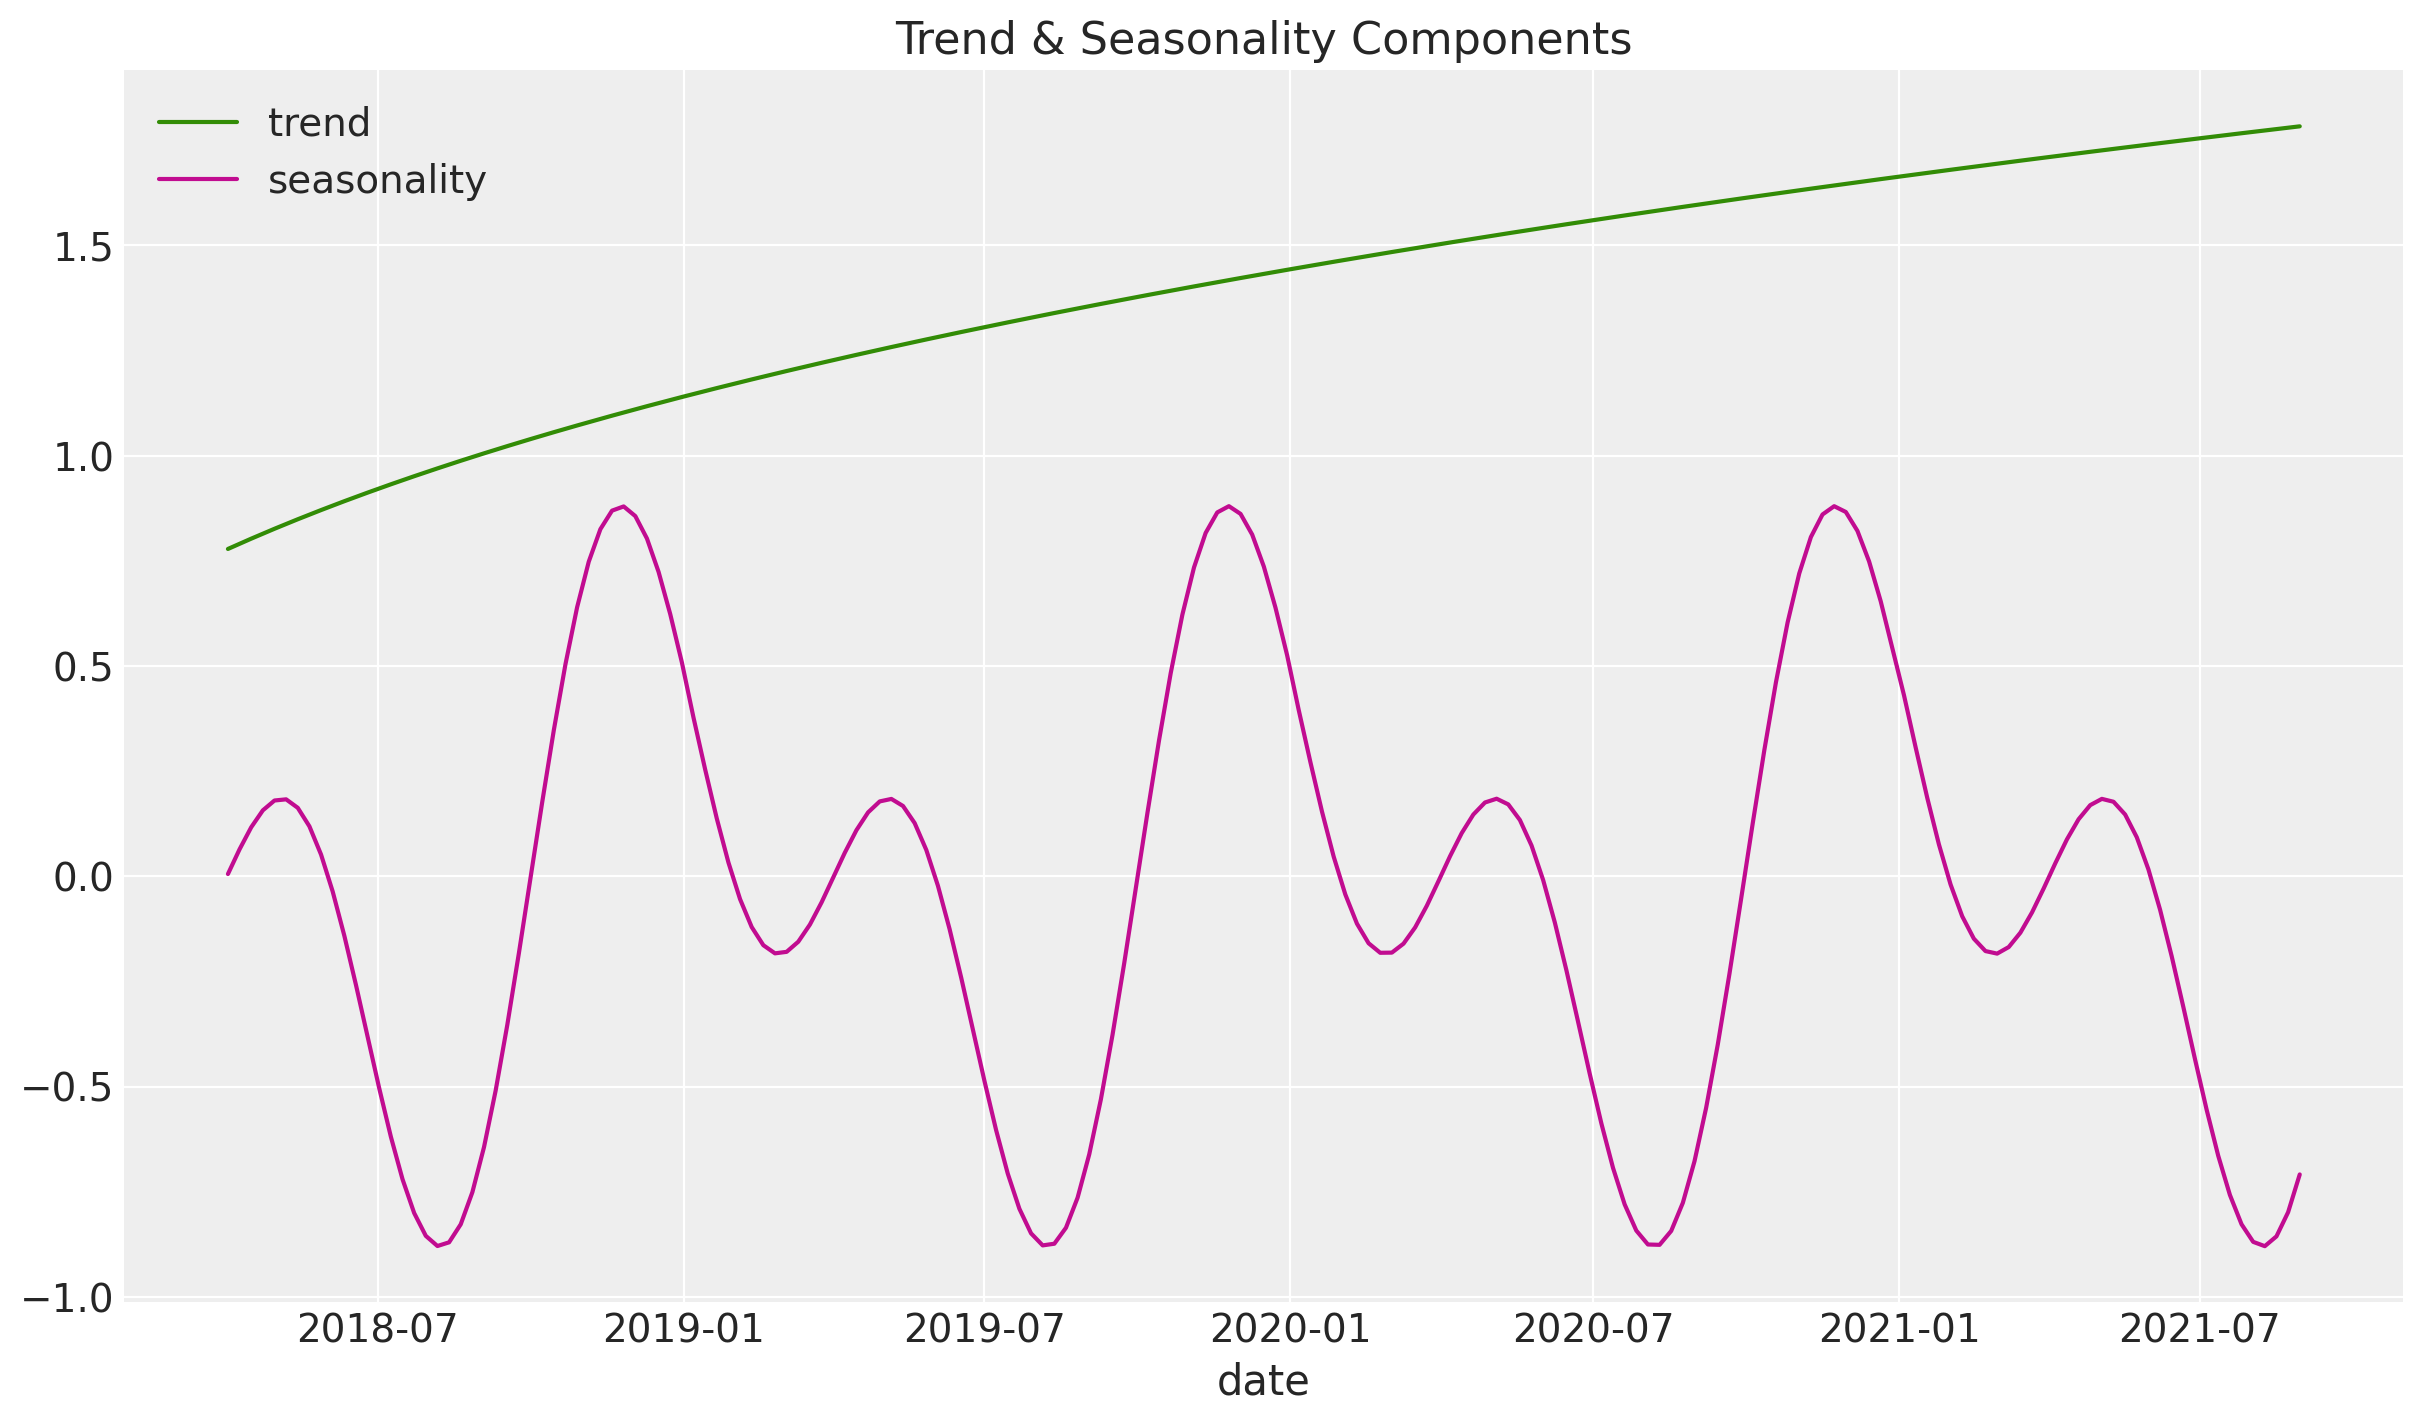

In [7]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

### 4. Control Variables

We add two *events* where there was a remarkable peak in our target variable. We assume they are independent an not seasonal (e.g. launch of a particular product). 

In [8]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

### 5. Target Variable

Finally, we define the target variable (sales) $y$. We assume it is a linear combination of the effect signal, the trend and the seasonal components, plus the two events and an intercept. We also add some Gaussian noise.

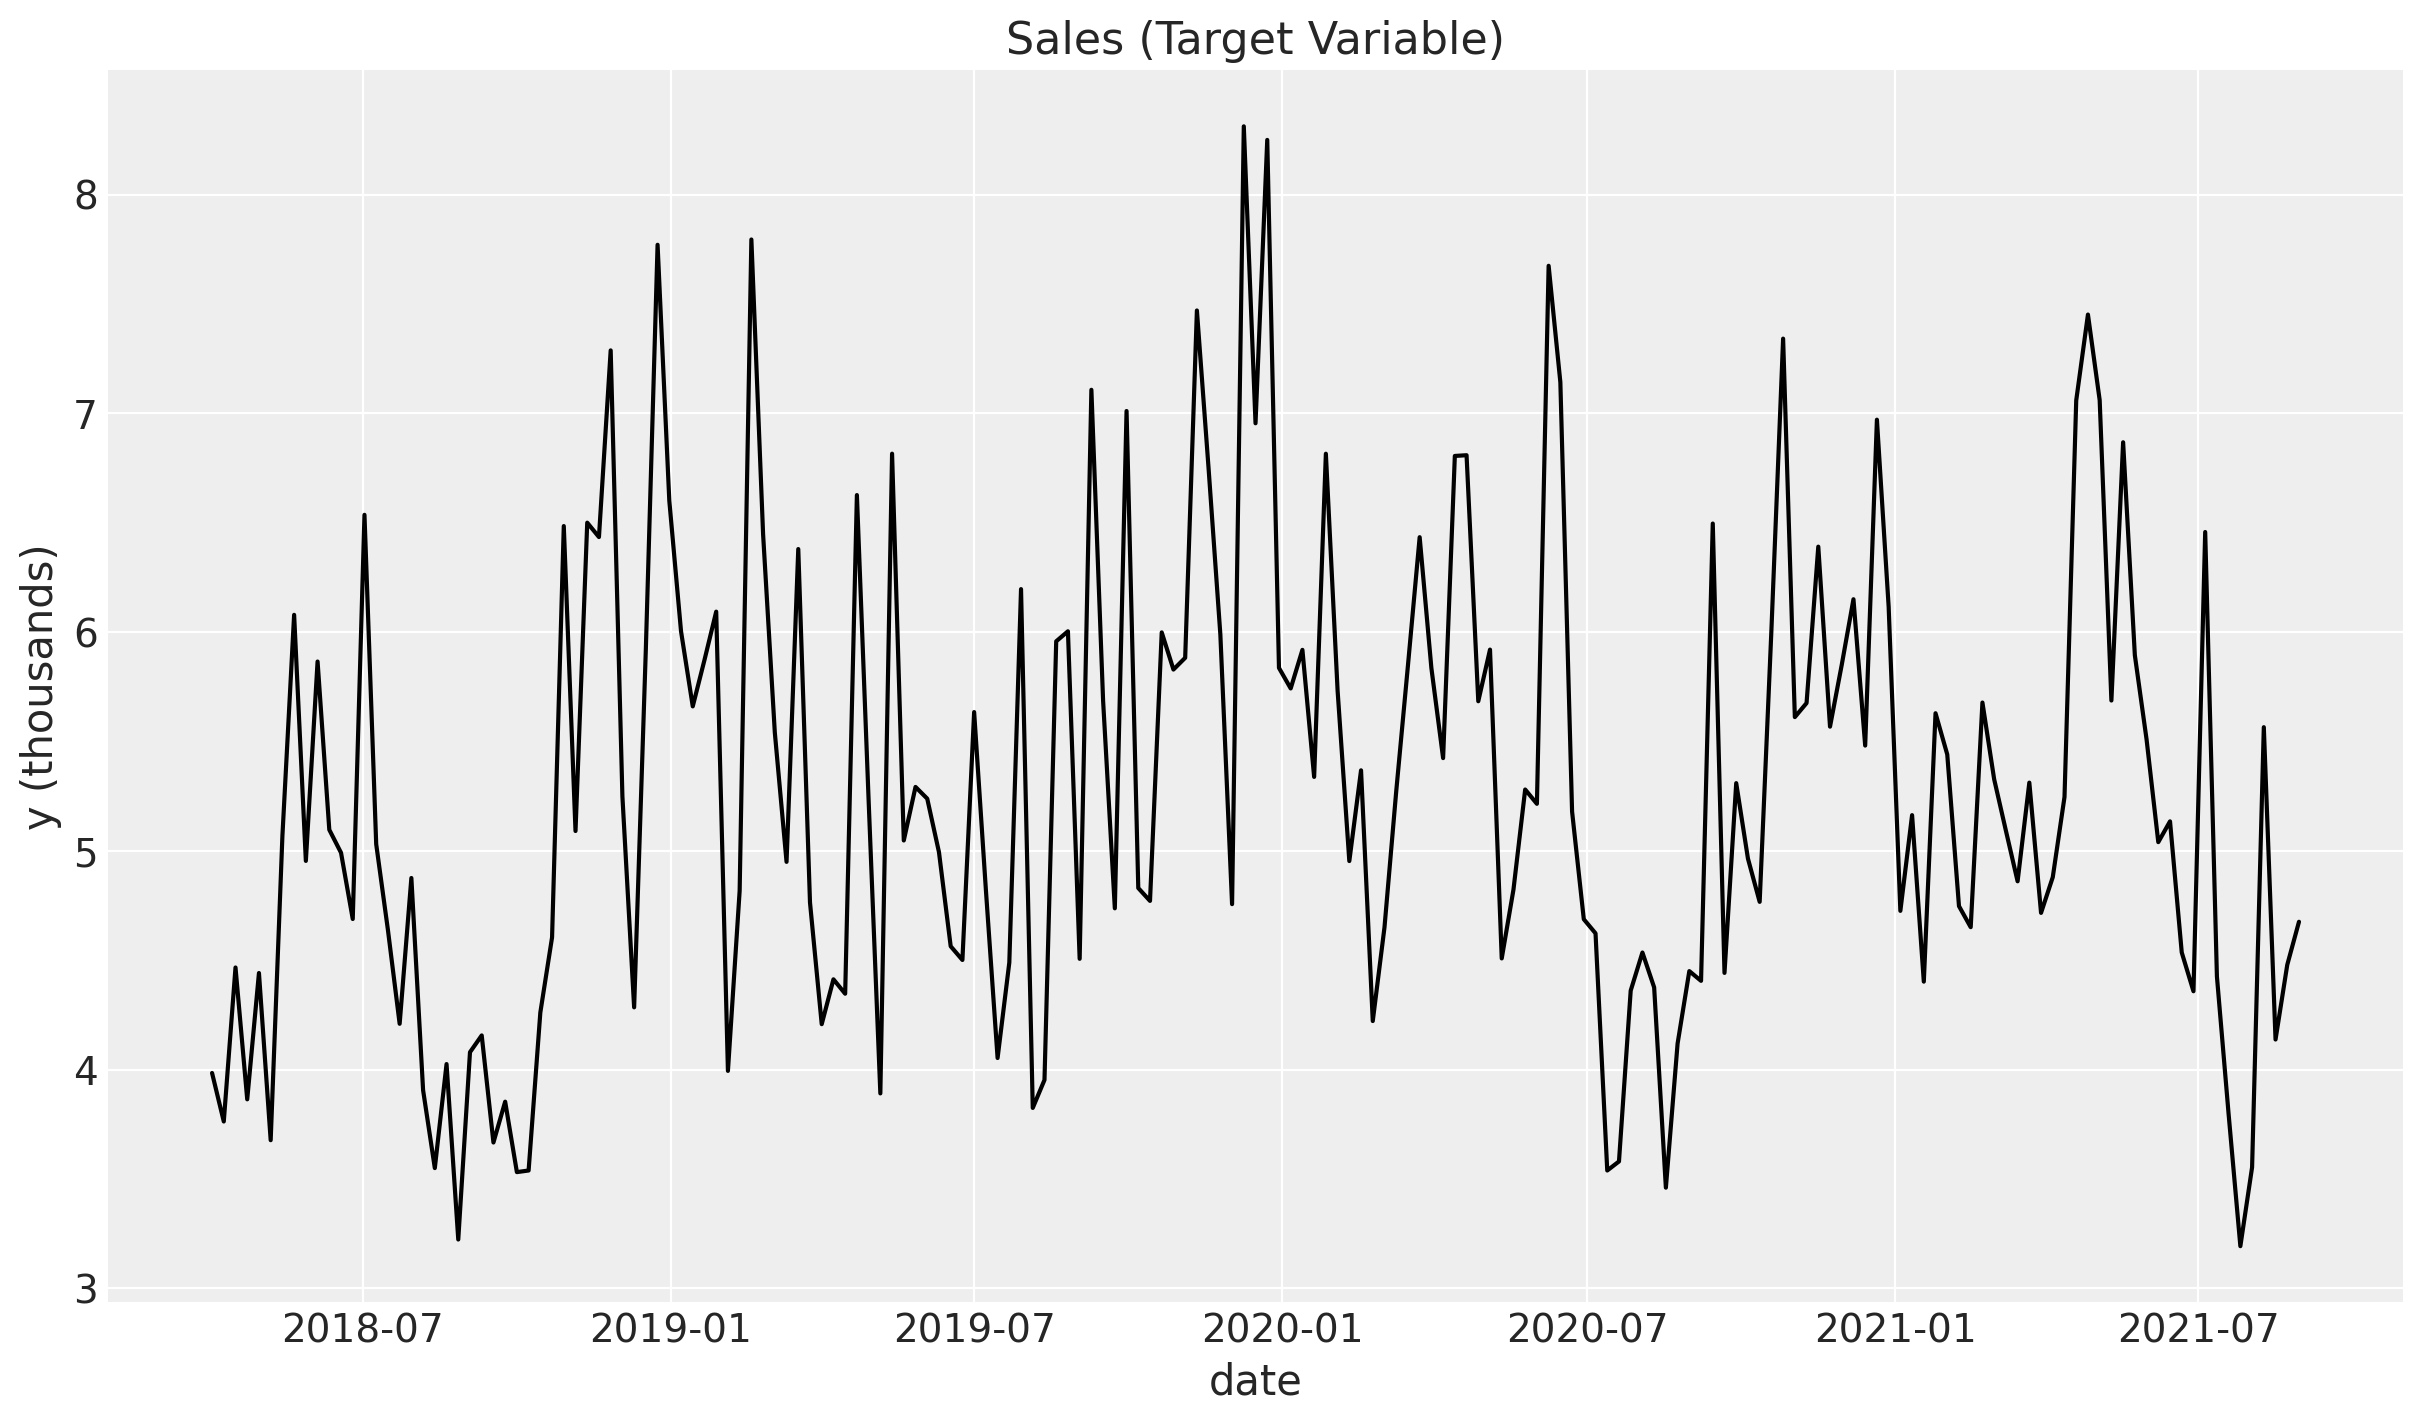

In [9]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1
beta_1 = 3.0
beta_2 = 2.0
betas = [beta_1, beta_2]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

### 6. Media Contribution Interpretation

From the data generating process we can compute the relative contribution of each channel to the target variable. We will recover these values back from the model.

In [10]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")

Contribution Share of x1: 0.81
Contribution Share of x2: 0.19


We can obtain the contribution plots for each channel where we clearly see the effect of the adstock and saturation transformations.

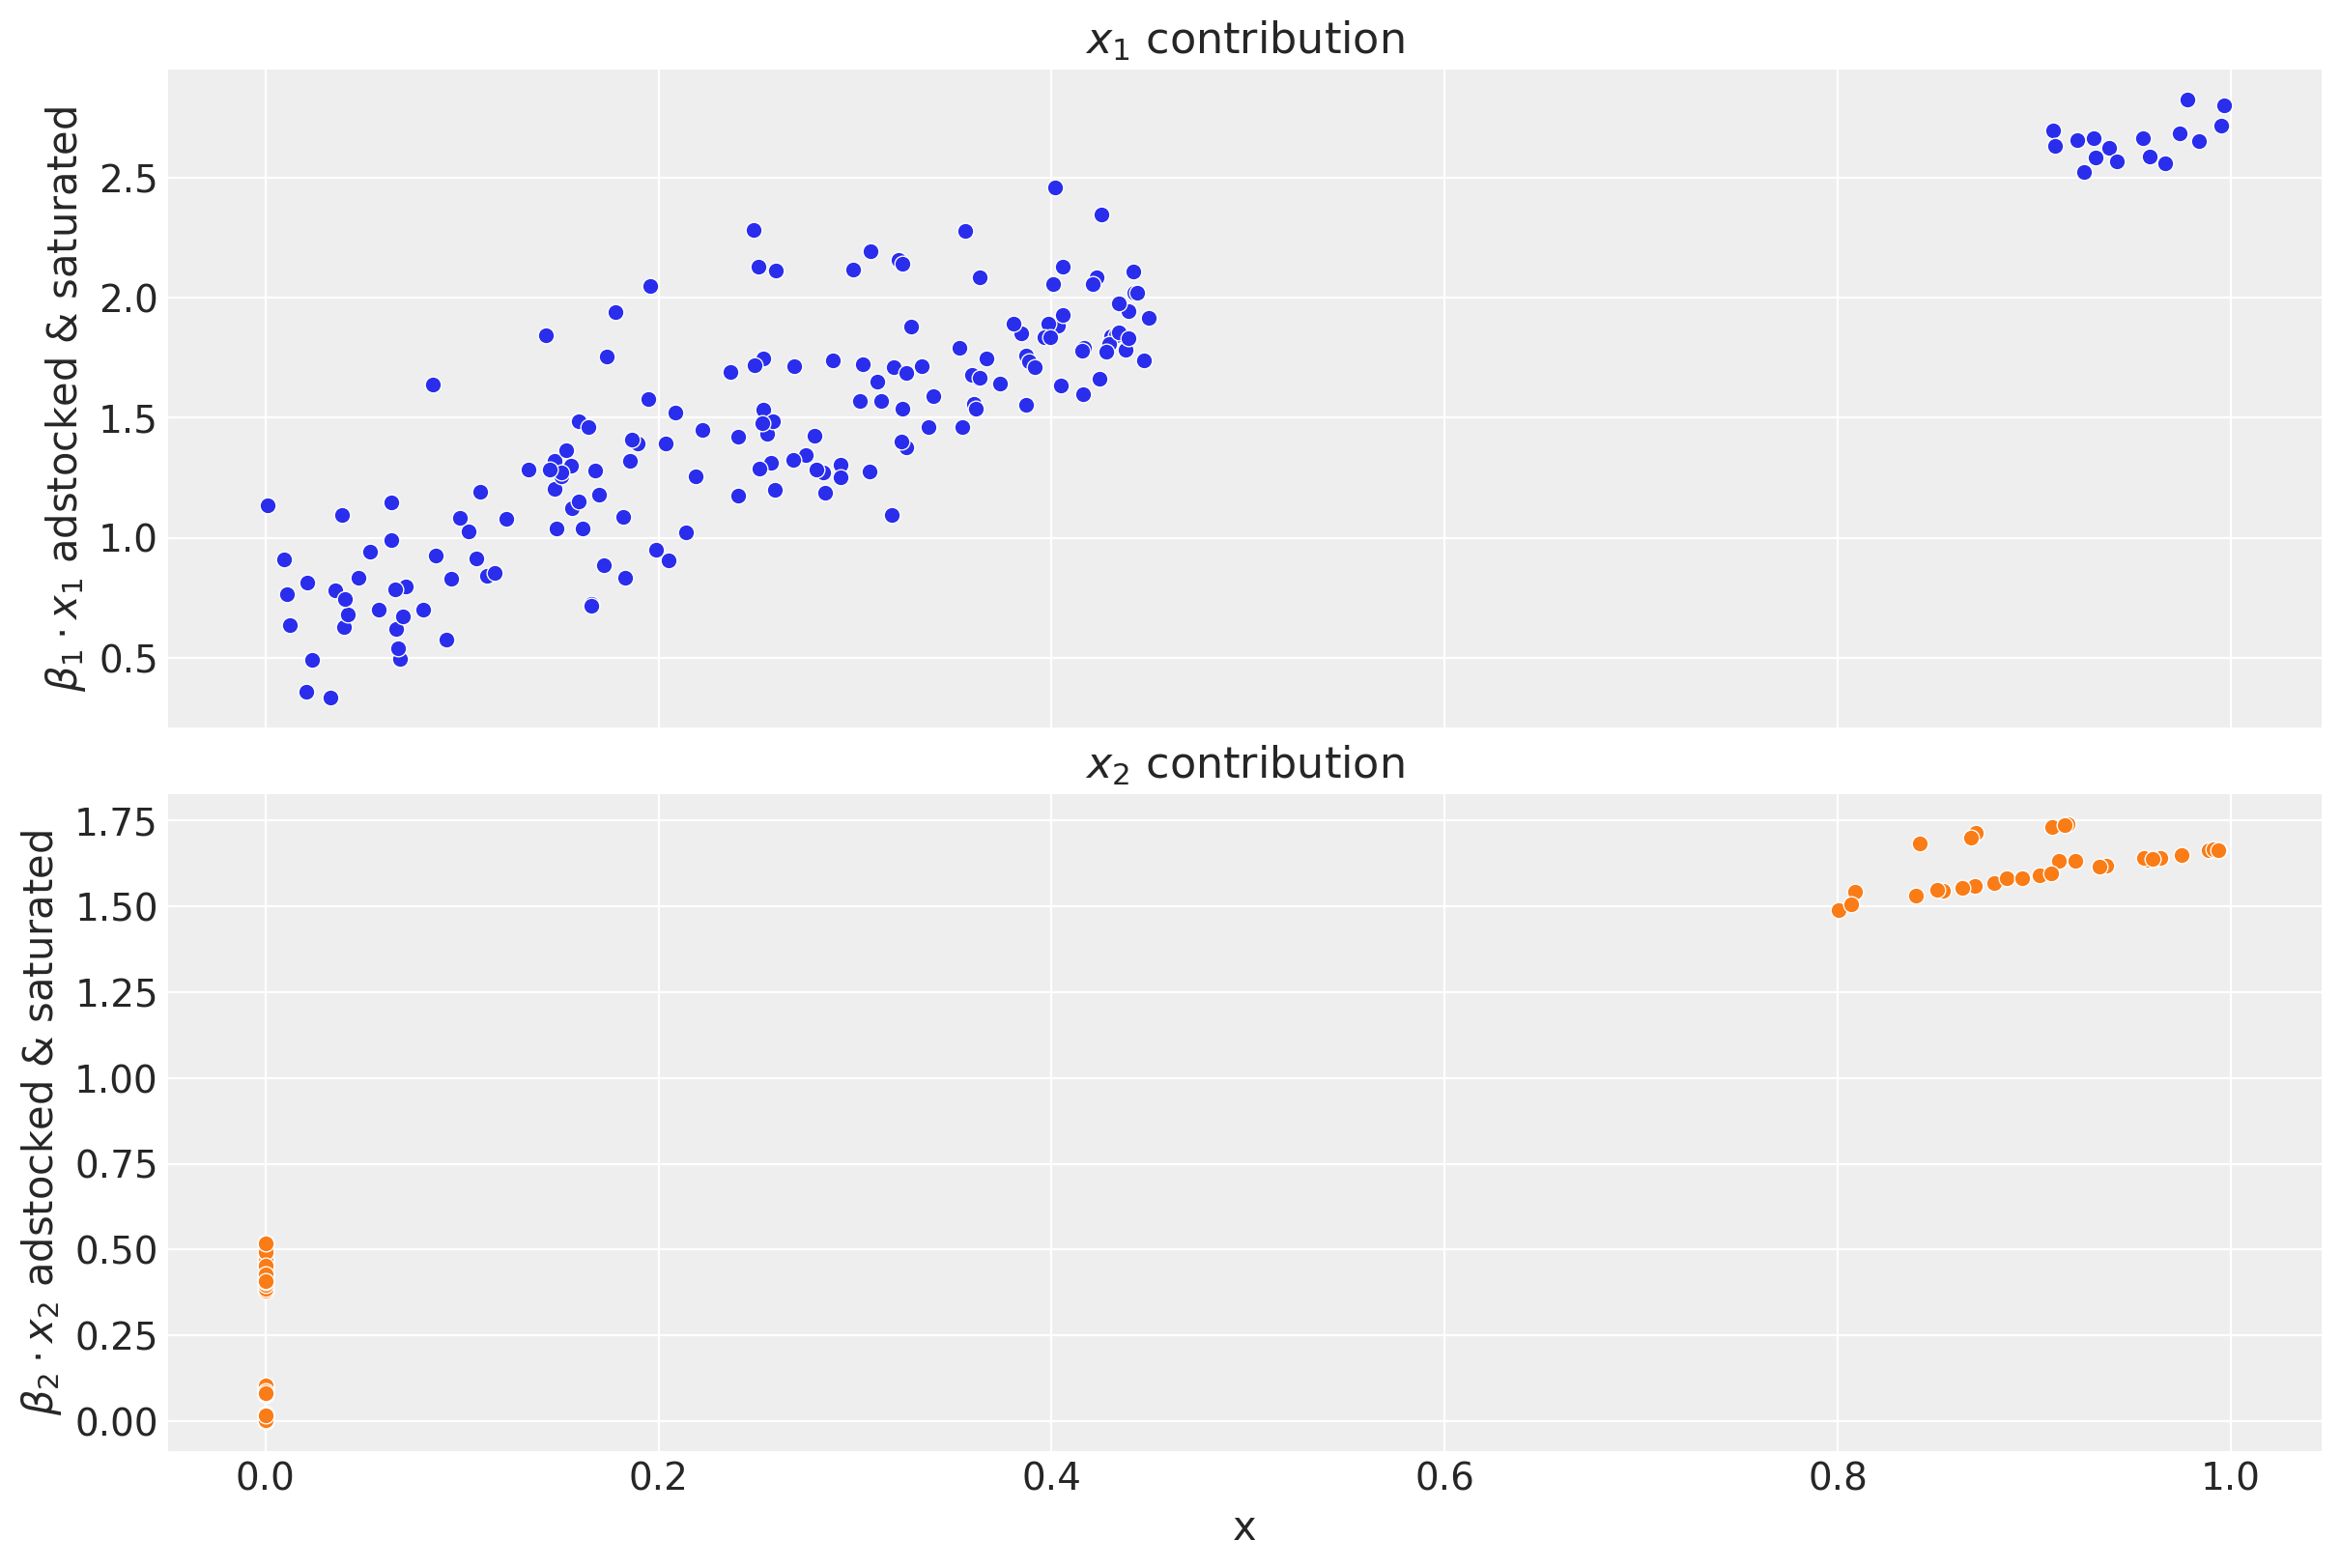

In [11]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

This plot shows some interesting aspects of the media contribution: 

- The adstock effect is reflected in the non-zero contribution of the channel even when the spend is zero.
- One clearly see the saturation effect as the contribution growth (slope) decreases as the spend increases.

As we will see in Part II of this notebook, we will recover these plots from the model!

We see that channel $x_{1}$ has a higher contribution than $x_{2}$. This could be explained by the fact that there was more spend in channel  $x_{1}$ than in channel $x_{2}$:

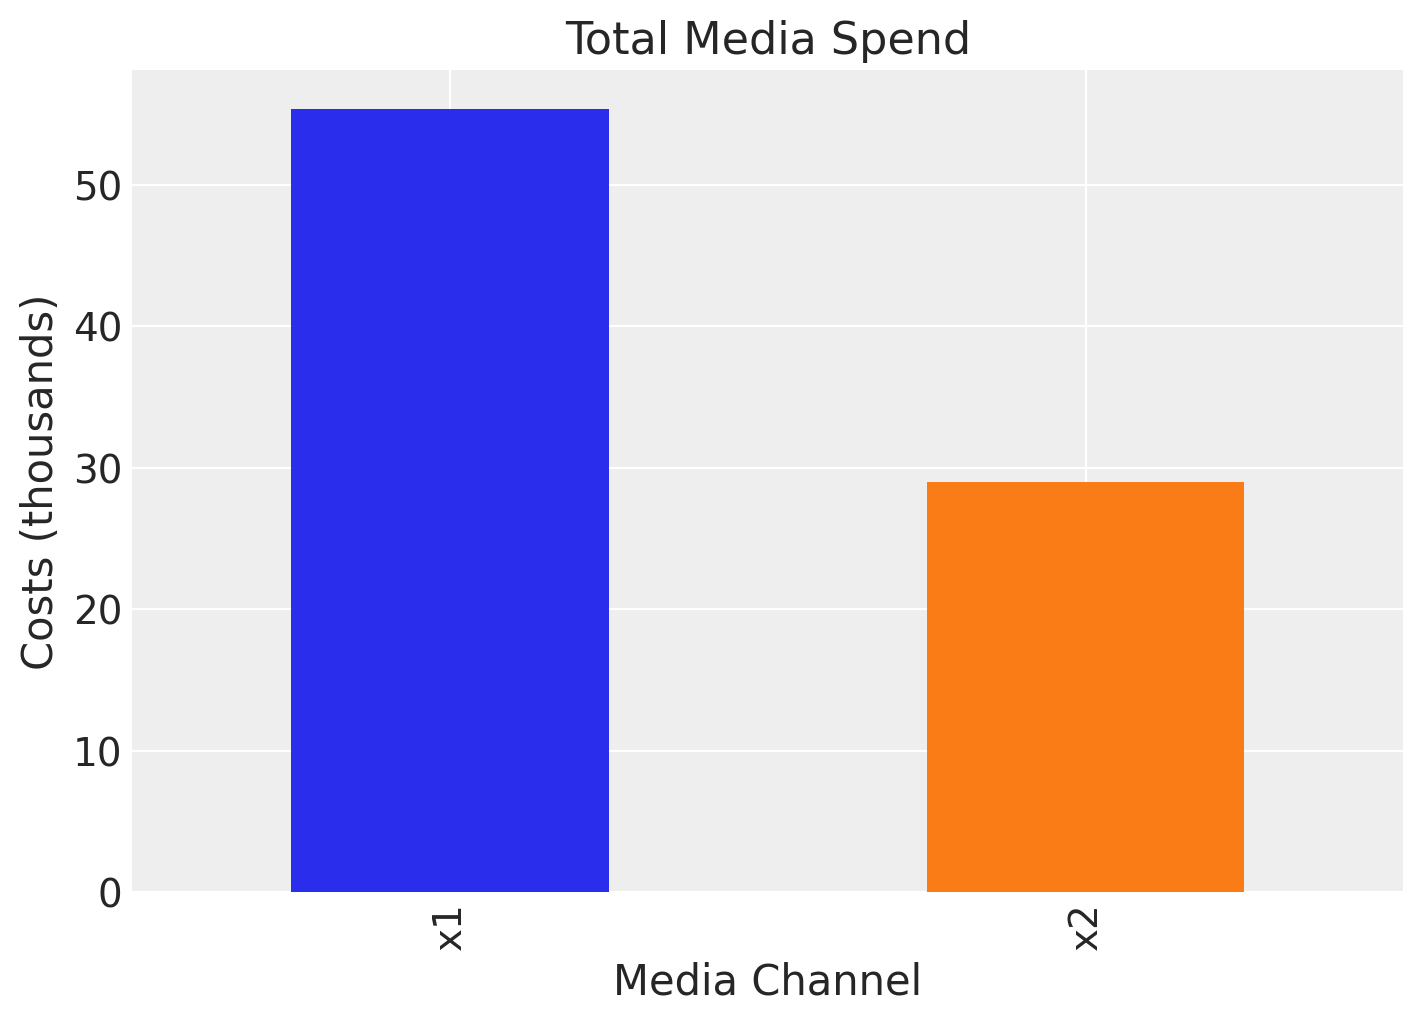

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2"]].sum().plot(kind="bar", color=["C0", "C1"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");

However, one usually is not only interested in the contribution itself but rather the Return on Ad Spend (ROAS). That is, the contribution divided by the cost. We can compute the ROAS for each channel as follows:

In [13]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()

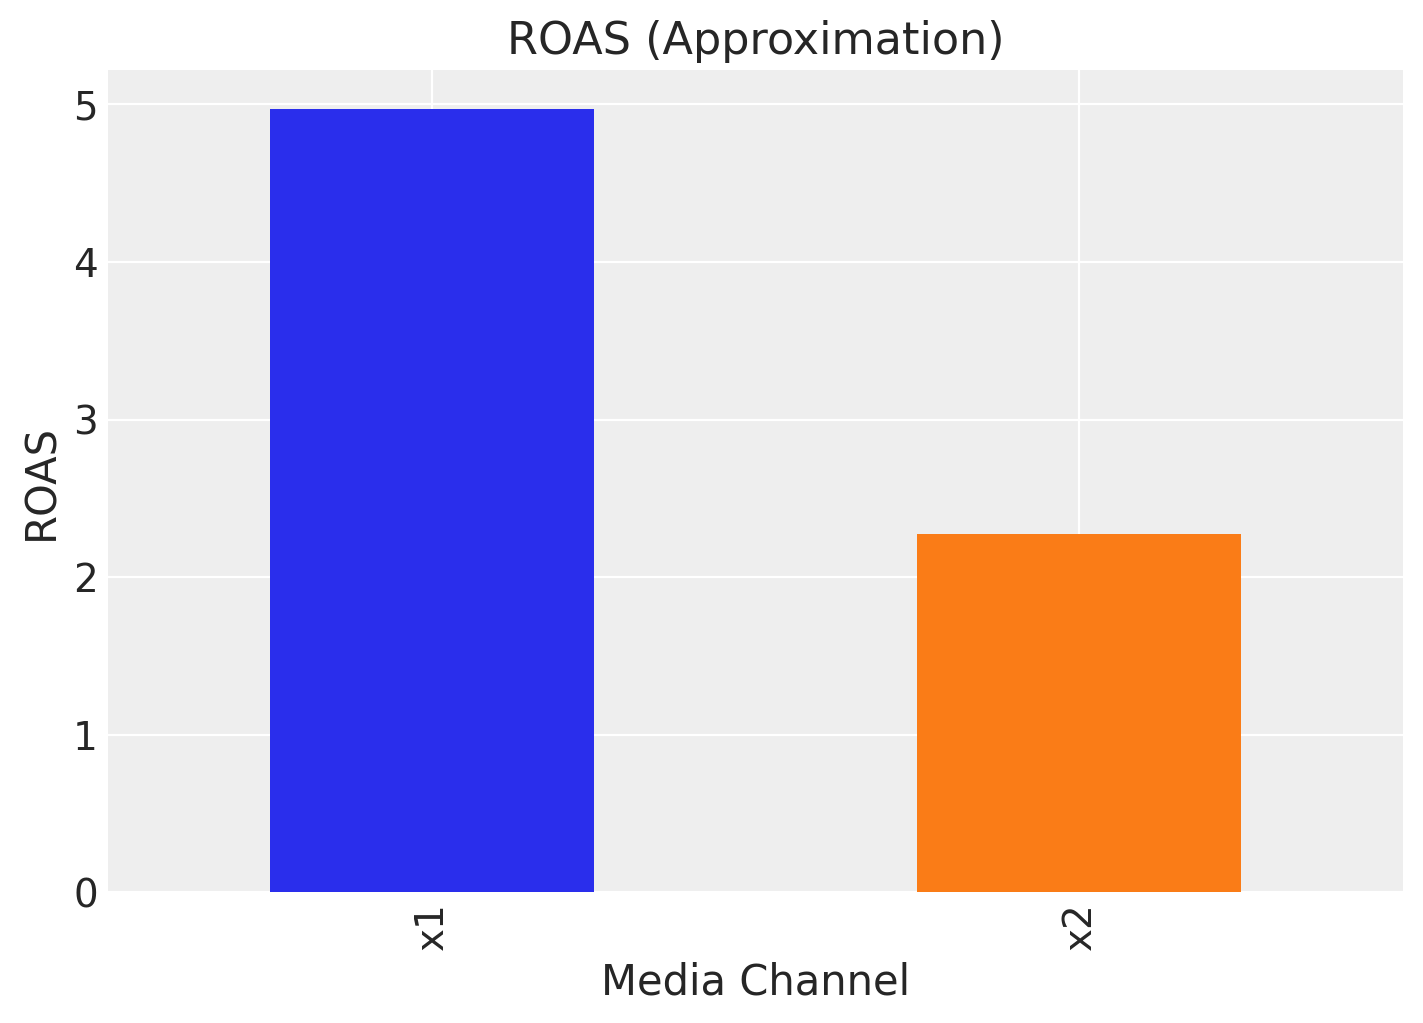

In [14]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2], index=["x1", "x2"]).plot(
        kind="bar", color=["C0", "C1"]
    )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

That is, channel $x_{1}$ seems to be more efficient than channel $x_{2}$.

**Remark:** We recommended reading Section 4.1 in [Jin, Yuxue, et al. “Bayesian methods for media mix modeling with carryover and shape effects.” (2017)](https://research.google/pubs/pub46001/) for a detailed explanation of the ROAS (and mROAS). In particular:
- If we transform our target variable $y$ (e.g. with a log transformation), one needs to be careful with the ROAS computation as setting the spend to zero does not commute with the transformation.
- One has to be careful with the adstock effect so that we include a carryover period to fully account for the effect of the spend. The ROAS estimation above is an approximation.

### 7. Data Output

We of course will not have all of these features in our real data. Let's filter out the features we will use for modeling:

In [15]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120


## Part II: Modeling

On this second part, we focus on the modeling process. We will use the data generated in Part I.

## 1. Feature Engineering

Assuming we did an EDA and we have a good understanding of the data (we did not do it here as we generated the data ourselves, but please never skip the EDA!), we can start building our model. One thing we immediately see is the seasonality and the trend component. We can generate features ourselves as *control variables*, for example using a uniformly increasing straight line to model the trend component. In addition, we include *dummy variables* to encode the `event_1`  and `event_2` contributions.

For the seasonality component we use Fourier modes (similar as in [Prophet](https://facebook.github.io/prophet/)). We do not need to add the Fourier modes by hand as they are handled by the model API through the `yearly_seasonality` argument (see below). We use 4 modes for the seasonality component.

In [16]:
# trend feature
data["t"] = range(n)

data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3.984662,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3.762872,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4.466967,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3.864219,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4.441625,0.386745,0.0,0.0,0.0,120,4


## 2. Model Specification

We can specify the model structure using the `DelayedSaturatedMMM` class. This class, handles a lot of internal boilerplate code for us such us scaling the data (see details below) and handy diagnostics and reporting plots. One great feature is that we can specify the channel priors distributions ourselves, which fundamental component of the [bayesian workflow](https://arxiv.org/abs/2011.01808) as we can incorporate our prior knowledge into the model. This is one of the most important advantages of using a bayesian approach. Let's see how we can do it.

As we do not know much more about the channels, we start with a simple heuristic: 

1. The channel contributions should be positive, so we can for example use a [`HalfNormal`](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.HalfNormal.html) distribution as prior. We need to set the `sigma` parameter per channel. The higher the `sigma`, the more "freedom" it has to fit the data. To specify `sigma` we can use the following point.

2. We expect channels where we spend the most to have more attributed sales , before seeing the data. This is a very reasonable assumption (note that we are not imposing anything at the level of efficiency!).

How to incorporate this heuristic into the model? To begin with, it is important to note that the `DelayedSaturatedMMM` class scales the target and input variables through an [`MaxAbsScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) transformer from [`scikit-learn`](https://scikit-learn.org/stable/), its important to specify the priors in the scaled space (i.e. between 0 and 1). One way to do it is to use the spend share as the `sigma` parameter for the `HalfNormal` distribution. We can actually add a scaling factor to take into account the support of the distribution.

First, let's compute the share of spend per channel:

In [17]:
total_spend_per_channel = data[["x1", "x2"]].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

x1    0.65632
x2    0.34368
dtype: float64

Next, we specify the `sigma` parameter per channel: 

In [20]:
# The scale necessary to make a HalfNormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

n_channels = 2

prior_sigma = HALFNORMAL_SCALE * n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[2.1775326025486734, 1.1402608773919387]

Delayed Saturated MMM follows sklearn convention, so we need to split our data into X (predictors) and y(target value)

In [21]:
X = data.drop('y',axis=1)
y = data['y']

model_config is an optional parameter that allows for user-defined priors to be applied to the model.
Each model_config entry contains a string key which corresponds to a name of a distribution registered inside our model. It's value is a dictionary conitaining key-value pairs describing input parameters of specific distribution, and 'dims' field which allows for specifying the dimentions of that distribution. In case you wish to apply your own priors, just copy the model_config definition above, modify it's content and pass it to DelayedSaturatedMMM.

If you're not sure how to define your own priors, you can use default_model_config property of DelayedSaturatedMMM to see the required structure:


In [20]:
dummy_model = DelayedSaturatedMMM(date_column = '', channel_columns= '', adstock_max_lag = 4)
dummy_model.default_model_config

{'intercept': {'mu': 0, 'sigma': 2},
 'beta_channel': {'sigma': 2, 'dims': ('channel',)},
 'alpha': {'alpha': 1, 'beta': 3, 'dims': ('channel',)},
 'lam': {'alpha': 3, 'beta': 1, 'dims': ('channel',)},
 'sigma': {'sigma': 2},
 'gamma_control': {'mu': 0, 'sigma': 2, 'dims': ('control',)},
 'mu': {'dims': ('date',)},
 'likelihood': {'dims': ('date',)},
 'gamma_fourier': {'mu': 0, 'b': 1, 'dims': 'fourier_mode'}}

You can change only the prior parameters that you wish, no need to alter all of them, unless you'd like to!

In [21]:
custom_beta_channel_prior = {'beta_channel': {'sigma': prior_sigma, 'dims': ('channel',)}}
my_model_config = {**dummy_model.default_model_config, **custom_beta_channel_prior}

**Remark:** For the prior specification there is no right or wrong answer. It all depends on the data, the context and the assumptions you are willing to make. It is always recommended to do some prior predictive sampling and sensitivity analysis to check the impact of the priors on the posterior. We skip this here for the sake of simplicity. If you are not sure about specific priors, the `DelayedSaturatedMMM` class has some default priors that you can use as a starting point.

Model sampler allows specifying set of parameters that will be passed to fit the same way as the kwargs are getting passed so far. It doesn't disable the fit kwargs, but rather extend them, to enable customizable and preservable configuration. By default the sampler_config for DelayedSaturatedMMM is empty. But if you'd like to use it, you can define it like showed below: 

In [22]:
sampler_config= {"progressbar": True}

Now we are ready to use the `DelayedSaturatedMMM` class to define the model.

In [23]:
mmm = DelayedSaturatedMMM(
    model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    channel_columns=["x1", "x2"],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=8,
    yearly_seasonality=2,
)

Observe how the media transformations were handled by the class `DelayedSaturatedMMM`.

## 3. Model Fitting

We can now fit the model:

In [ ]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


You can access `pymc` model as `mmm.model`.

In [ ]:
type(mmm.model)

We can easily see the explicit model structure:

In [ ]:
pm.model_to_graphviz(model=mmm.model)

## 4. Model Diagnostics

The `fit_result` attribute contains the `pymc` trace object.

In [ ]:
mmm.fit_result

We can therefore use all the `pymc` machinery to run model diagnostics. First, let's see the summary of the trace:

In [ ]:
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
)

Observe that the estimated parameters for $\alpha$ and $\lambda$ are very close to the ones we set in the data generation process! Let's plot the trace for the parameters:

In [ ]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "beta_channel",
        "alpha",
        "lam",
        "gamma_control",
        "gamma_fourier",
        "sigma",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

Next, we can plot the posterior predictive distribution for the target variable:

In [ ]:
mmm.plot_posterior_predictive(original_scale=True);

The fit looks very good (as expected)!

We can decompose the posterior predictive distribution into the different components:

In [ ]:
mmm.plot_components_contributions();

**Remark:** This plot shows the decomposition of the normalized target variable when by dividing by its maximum value. Do not forget that internally we are scaling the variables to make the model sample more efficiently. You can recover the transformations from the API methods, e.g.

In [ ]:
mmm.get_target_transformer()

A similar decomposition can be achieved using an area plot:

In [ ]:
groups = {
    "Base": [
        "intercept",
        "event_1",
        "event_2",
        "t",
        "sin_order_1",
        "sin_order_2",
        "cos_order_1",
        "cos_order_2",
    ],
    "Channel 1": ["x1"],
    "Channel 2": ["x2"],
}

fig = mmm.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "Channel 1": "C0",
            "Channel 2": "C1",
            "Base": "gray",
            "Seasonality": "black",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

Note that this only works if the contributions of the channel or control variable are strictly positive.

We can extract the all the input variables contributions over time, i.e. the regression coefficients times the feature values, as follows:

In [ ]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

## 5. Media Parameters

We can deep-dive into the media transformation parameters. We want to compare the posterior distributions against the true values.

In [ ]:
fig = mmm.plot_channel_parameter(param_name="alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

In [ ]:
fig = mmm.plot_channel_parameter(param_name="lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.legend(loc="upper right");

We indeed see that our media parameter were successfully recovered!

## 6. Media Deep-Dive

First we can compute the relative contribution of each channel to the target variable. Note that we recover the true values!

In [ ]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

Next, we can plot the relative contribution of each channel to the target variable. Again, we get very close values as the ones obtained in Part I.

In [ ]:
fig = mmm.plot_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

## 7. Contribution  Recovery

Next, we can plot the contribution of each channel to the target variable over time.

In [ ]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=2, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2"]):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=df["date_week"],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color="black",
        label=f"{x} true contribution",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=df["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=f"{x} $94%$ HDI contribution",
        alpha=0.4,
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=df["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        alpha=0.8,
        ax=ax[i],
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

The results look great! We therefore successfully recovered the true values from the data generation process. We have also seen how easy is to use the `DelayedSaturatedMMM` class to fit media mix models! It takes over the model specification and the media transformations, while having all the flexibility of `pymc`!

## 8. ROAS

Finally, we can compute the (approximate) ROAS posterior distribution for each channel.

In [ ]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    / data[["x1", "x2"]].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

We see that the ROAS posterior distributions are centered around the true values! We also see that, even considering the uncertainty, channel $x_{1}$ is more efficient than channel $x_{2}$. 